In [2]:
from analyze import analyze_data
from utils import RequestData
import json
from datetime import datetime
from zoneinfo import ZoneInfo

def get_performance(report):
    loadgen_data = report['loadgen_data']

    total_request_count = len(loadgen_data)
    no_response_count = 0
    error_count = 0
    requests = []
    for request_data in loadgen_data:
        if 'error' not in request_data.keys():
            request = RequestData.init_from_dict(request_data)
            requests.append(request)
            continue

        if request_data == {'error': 'No response!'}:
            no_response_count += 1
        else:
            error_count += 1

    ttft_attain_count = 0
    tbt_attain_count = 0
    total_attain_count = 0
    for request in requests:
        ttft_attain, tbt_attain = request.satisfy_SLO()
        if ttft_attain:
            ttft_attain_count += 1
        
        if tbt_attain:
            tbt_attain_count += 1
        
        if ttft_attain and tbt_attain:
            total_attain_count += 1

    ttft_attain_rate = ttft_attain_count / total_request_count
    tbt_attain_rate = tbt_attain_count / total_request_count
    total_attain_rate = total_attain_count / total_request_count

    # print(f"Among {total_request_count} requests, {ttft_attain_count} attain TTFT, {tbt_attain_count} attain TBT, {total_attain_count} attain total")
    # print(f"total attain rate: {total_attain_rate*100:.1f}%, TTFT attain rate: {ttft_attain_rate*100:.1f}%, TBT attain rate: {tbt_attain_rate*100:.1f}%")
    return ttft_attain_rate, tbt_attain_rate, total_attain_rate

def get_cost(report):

    req_counter = report['prom_data']
    metric_name = "router:ins_counter"
    start_str = report.get('router_start_time', 'N/A')
    end_str = report.get('router_end_time', 'N/A')
    tz_sg = ZoneInfo("Asia/Singapore")
    router_start_time = datetime.fromisoformat(start_str).replace(tzinfo=tz_sg).timestamp()
    router_end_time = datetime.fromisoformat(end_str).replace(tzinfo=tz_sg).timestamp()

    router_metrics = req_counter.get("router", {})
    cost_map = {}
    for i, (model_name, metrics) in enumerate(router_metrics.items()):
        req_counter_values = metrics.get(metric_name, [])
        req_counter_values = [
            t for t in req_counter_values 
            if float(t[0]) <= router_end_time
        ]
        cost_values = [float(t[1]) for t in req_counter_values]
        avg_cost = sum(cost_values) / len(cost_values) if cost_values else 0
        cost_map[model_name] = avg_cost
    return cost_map



In [3]:
run_log_dirs_list = [
    [
        "/mnt/network_drive/lrq/logs/logs_2025-07-28-16-36-29/run_0",
        "/mnt/network_drive/lrq/logs/logs_2025-07-28-16-36-29/run_1",
        "/mnt/network_drive/lrq/logs/logs_2025-07-28-16-36-29/run_2",
        "/mnt/network_drive/lrq/logs/logs_2025-07-28-16-36-29/run_3",
        "/mnt/network_drive/lrq/logs/logs_2025-07-28-16-36-29/run_4",
    ],
    

# [
#     "/mnt/network_drive/lrq/logs/logs_2025-07-28-17-41-00/run_0",
#     "/mnt/network_drive/lrq/logs/logs_2025-07-28-17-41-00/run_1",
#     "/mnt/network_drive/lrq/logs/logs_2025-07-28-17-41-00/run_2",
#     "/mnt/network_drive/lrq/logs/logs_2025-07-28-17-41-00/run_3",
#     "/mnt/network_drive/lrq/logs/logs_2025-07-28-17-41-00/run_4",
# ],
[
    "/mnt/network_drive/lrq/logs/logs_2025-07-28-17-51-45/run_0",
    "/mnt/network_drive/lrq/logs/logs_2025-07-28-17-51-45/run_1",
    "/mnt/network_drive/lrq/logs/logs_2025-07-28-17-51-45/run_2",
    "/mnt/network_drive/lrq/logs/logs_2025-07-28-17-51-45/run_3",
    "/mnt/network_drive/lrq/logs/logs_2025-07-28-17-51-45/run_4",
],
[
    "/mnt/network_drive/lrq/logs/logs_2025-07-28-17-04-12/run_0",
    "/mnt/network_drive/lrq/logs/logs_2025-07-28-17-04-12/run_1",
    "/mnt/network_drive/lrq/logs/logs_2025-07-28-17-04-12/run_2",
    "/mnt/network_drive/lrq/logs/logs_2025-07-28-17-04-12/run_3",
    "/mnt/network_drive/lrq/logs/logs_2025-07-28-17-04-12/run_4",
],
[
    "/mnt/network_drive/lrq/logs/logs_2025-07-28-19-18-23/run_0",
    "/mnt/network_drive/lrq/logs/logs_2025-07-28-19-18-23/run_1",
    "/mnt/network_drive/lrq/logs/logs_2025-07-28-19-18-23/run_2",
    "/mnt/network_drive/lrq/logs/logs_2025-07-28-19-18-23/run_3",
    "/mnt/network_drive/lrq/logs/logs_2025-07-28-19-18-23/run_4",
],
[
    "/mnt/network_drive/lrq/logs/logs_2025-07-28-20-17-07/run_0",
    "/mnt/network_drive/lrq/logs/logs_2025-07-28-20-17-07/run_1",
    "/mnt/network_drive/lrq/logs/logs_2025-07-28-20-17-07/run_2",
    "/mnt/network_drive/lrq/logs/logs_2025-07-28-20-17-07/run_3",
    "/mnt/network_drive/lrq/logs/logs_2025-07-28-20-17-07/run_4",
]
]
ttft_attains_list = []
tpot_attains_list = []
costs_list = []

for run_log_dirs in run_log_dirs_list:
    ttft_attains = []
    tpot_attains = []
    costs = []
    for run_log_dir in run_log_dirs:
        ins_counter_metric = f"router:ins_counter"
        metrics_list = [ins_counter_metric]
        report_file_path = analyze_data(run_log_dir, metrics_list)
        with open(report_file_path, 'r') as f:
            report = json.load(f)

        ttft_attain_rate, tbt_attain_rate, total_attain_rate = get_performance(report)
        cost_map = get_cost(report)

        ttft_attains.append(ttft_attain_rate)
        tpot_attains.append(tbt_attain_rate)
        costs.append(sum(cost_map.values()))
    ttft_attains_list.append(ttft_attains)
    tpot_attains_list.append(tpot_attains)
    costs_list.append(costs)



Starting Prometheus...


ts=2025-07-28T12:51:34.378Z caller=main.go:573 level=info msg="No time or size retention was set so using the default time retention" duration=15d
ts=2025-07-28T12:51:34.378Z caller=main.go:617 level=info msg="Starting Prometheus Server" mode=server version="(version=2.52.0, branch=HEAD, revision=879d80922a227c37df502e7315fad8ceb10a986d)"
ts=2025-07-28T12:51:34.379Z caller=main.go:622 level=info build_context="(go=go1.22.3, platform=linux/amd64, user=root@1b4f4c206e41, date=20240508-21:56:43, tags=netgo,builtinassets,stringlabels)"
ts=2025-07-28T12:51:34.379Z caller=main.go:623 level=info host_details="(Linux 5.4.0-216-generic #236-Ubuntu SMP Fri Apr 11 19:53:21 UTC 2025 x86_64 5943939d7989 (none))"
ts=2025-07-28T12:51:34.379Z caller=main.go:624 level=info fd_limits="(soft=1048576, hard=1048576)"
ts=2025-07-28T12:51:34.379Z caller=main.go:625 level=info vm_limits="(soft=unlimited, hard=unlimited)"
ts=2025-07-28T12:51:34.385Z caller=web.go:568 level=info component=web msg="Start listeni

Running Python app...
query_metrics_list: ['router:ins_counter']
params_list: [{'query': 'router:ins_counter', 'start': '2025-07-28T08:39:48Z', 'end': '2025-07-28T10:39:48Z', 'step': '1s'}]
Starting Prometheus...


ts=2025-07-28T12:51:45.992Z caller=main.go:573 level=info msg="No time or size retention was set so using the default time retention" duration=15d
ts=2025-07-28T12:51:45.992Z caller=main.go:617 level=info msg="Starting Prometheus Server" mode=server version="(version=2.52.0, branch=HEAD, revision=879d80922a227c37df502e7315fad8ceb10a986d)"
ts=2025-07-28T12:51:45.992Z caller=main.go:622 level=info build_context="(go=go1.22.3, platform=linux/amd64, user=root@1b4f4c206e41, date=20240508-21:56:43, tags=netgo,builtinassets,stringlabels)"
ts=2025-07-28T12:51:45.992Z caller=main.go:623 level=info host_details="(Linux 5.4.0-216-generic #236-Ubuntu SMP Fri Apr 11 19:53:21 UTC 2025 x86_64 a121848958dd (none))"
ts=2025-07-28T12:51:45.992Z caller=main.go:624 level=info fd_limits="(soft=1048576, hard=1048576)"
ts=2025-07-28T12:51:45.992Z caller=main.go:625 level=info vm_limits="(soft=unlimited, hard=unlimited)"
ts=2025-07-28T12:51:45.998Z caller=web.go:568 level=info component=web msg="Start listeni

Running Python app...
query_metrics_list: ['router:ins_counter']
params_list: [{'query': 'router:ins_counter', 'start': '2025-07-28T08:39:46Z', 'end': '2025-07-28T10:39:46Z', 'step': '1s'}]
Starting Prometheus...


ts=2025-07-28T12:51:57.543Z caller=main.go:573 level=info msg="No time or size retention was set so using the default time retention" duration=15d
ts=2025-07-28T12:51:57.544Z caller=main.go:617 level=info msg="Starting Prometheus Server" mode=server version="(version=2.52.0, branch=HEAD, revision=879d80922a227c37df502e7315fad8ceb10a986d)"
ts=2025-07-28T12:51:57.544Z caller=main.go:622 level=info build_context="(go=go1.22.3, platform=linux/amd64, user=root@1b4f4c206e41, date=20240508-21:56:43, tags=netgo,builtinassets,stringlabels)"
ts=2025-07-28T12:51:57.544Z caller=main.go:623 level=info host_details="(Linux 5.4.0-216-generic #236-Ubuntu SMP Fri Apr 11 19:53:21 UTC 2025 x86_64 20e4040ca04f (none))"
ts=2025-07-28T12:51:57.544Z caller=main.go:624 level=info fd_limits="(soft=1048576, hard=1048576)"
ts=2025-07-28T12:51:57.544Z caller=main.go:625 level=info vm_limits="(soft=unlimited, hard=unlimited)"
ts=2025-07-28T12:51:57.551Z caller=web.go:568 level=info component=web msg="Start listeni

Running Python app...
query_metrics_list: ['router:ins_counter']
params_list: [{'query': 'router:ins_counter', 'start': '2025-07-28T08:39:51Z', 'end': '2025-07-28T10:39:51Z', 'step': '1s'}]
Starting Prometheus...


ts=2025-07-28T12:52:08.765Z caller=main.go:573 level=info msg="No time or size retention was set so using the default time retention" duration=15d
ts=2025-07-28T12:52:08.765Z caller=main.go:617 level=info msg="Starting Prometheus Server" mode=server version="(version=2.52.0, branch=HEAD, revision=879d80922a227c37df502e7315fad8ceb10a986d)"
ts=2025-07-28T12:52:08.765Z caller=main.go:622 level=info build_context="(go=go1.22.3, platform=linux/amd64, user=root@1b4f4c206e41, date=20240508-21:56:43, tags=netgo,builtinassets,stringlabels)"
ts=2025-07-28T12:52:08.765Z caller=main.go:623 level=info host_details="(Linux 5.4.0-216-generic #236-Ubuntu SMP Fri Apr 11 19:53:21 UTC 2025 x86_64 934dc137295d (none))"
ts=2025-07-28T12:52:08.765Z caller=main.go:624 level=info fd_limits="(soft=1048576, hard=1048576)"
ts=2025-07-28T12:52:08.765Z caller=main.go:625 level=info vm_limits="(soft=unlimited, hard=unlimited)"
ts=2025-07-28T12:52:08.771Z caller=web.go:568 level=info component=web msg="Start listeni

Running Python app...
query_metrics_list: ['router:ins_counter']
params_list: [{'query': 'router:ins_counter', 'start': '2025-07-28T08:39:46Z', 'end': '2025-07-28T10:39:46Z', 'step': '1s'}]
Starting Prometheus...


ts=2025-07-28T12:52:20.257Z caller=main.go:573 level=info msg="No time or size retention was set so using the default time retention" duration=15d
ts=2025-07-28T12:52:20.257Z caller=main.go:617 level=info msg="Starting Prometheus Server" mode=server version="(version=2.52.0, branch=HEAD, revision=879d80922a227c37df502e7315fad8ceb10a986d)"
ts=2025-07-28T12:52:20.257Z caller=main.go:622 level=info build_context="(go=go1.22.3, platform=linux/amd64, user=root@1b4f4c206e41, date=20240508-21:56:43, tags=netgo,builtinassets,stringlabels)"
ts=2025-07-28T12:52:20.257Z caller=main.go:623 level=info host_details="(Linux 5.4.0-216-generic #236-Ubuntu SMP Fri Apr 11 19:53:21 UTC 2025 x86_64 c137933a7684 (none))"
ts=2025-07-28T12:52:20.257Z caller=main.go:624 level=info fd_limits="(soft=1048576, hard=1048576)"
ts=2025-07-28T12:52:20.257Z caller=main.go:625 level=info vm_limits="(soft=unlimited, hard=unlimited)"
ts=2025-07-28T12:52:20.263Z caller=web.go:568 level=info component=web msg="Start listeni

Running Python app...
query_metrics_list: ['router:ins_counter']
params_list: [{'query': 'router:ins_counter', 'start': '2025-07-28T08:39:48Z', 'end': '2025-07-28T10:39:48Z', 'step': '1s'}]
Starting Prometheus...


ts=2025-07-28T12:52:31.652Z caller=main.go:573 level=info msg="No time or size retention was set so using the default time retention" duration=15d
ts=2025-07-28T12:52:31.652Z caller=main.go:617 level=info msg="Starting Prometheus Server" mode=server version="(version=2.52.0, branch=HEAD, revision=879d80922a227c37df502e7315fad8ceb10a986d)"
ts=2025-07-28T12:52:31.652Z caller=main.go:622 level=info build_context="(go=go1.22.3, platform=linux/amd64, user=root@1b4f4c206e41, date=20240508-21:56:43, tags=netgo,builtinassets,stringlabels)"
ts=2025-07-28T12:52:31.652Z caller=main.go:623 level=info host_details="(Linux 5.4.0-216-generic #236-Ubuntu SMP Fri Apr 11 19:53:21 UTC 2025 x86_64 44dfdc2e0f0c (none))"
ts=2025-07-28T12:52:31.652Z caller=main.go:624 level=info fd_limits="(soft=1048576, hard=1048576)"
ts=2025-07-28T12:52:31.652Z caller=main.go:625 level=info vm_limits="(soft=unlimited, hard=unlimited)"
ts=2025-07-28T12:52:31.658Z caller=web.go:568 level=info component=web msg="Start listeni

Running Python app...
query_metrics_list: ['router:ins_counter']
params_list: [{'query': 'router:ins_counter', 'start': '2025-07-28T09:55:14Z', 'end': '2025-07-28T11:55:14Z', 'step': '1s'}]
Starting Prometheus...


ts=2025-07-28T12:52:42.919Z caller=main.go:573 level=info msg="No time or size retention was set so using the default time retention" duration=15d
ts=2025-07-28T12:52:42.919Z caller=main.go:617 level=info msg="Starting Prometheus Server" mode=server version="(version=2.52.0, branch=HEAD, revision=879d80922a227c37df502e7315fad8ceb10a986d)"
ts=2025-07-28T12:52:42.919Z caller=main.go:622 level=info build_context="(go=go1.22.3, platform=linux/amd64, user=root@1b4f4c206e41, date=20240508-21:56:43, tags=netgo,builtinassets,stringlabels)"
ts=2025-07-28T12:52:42.919Z caller=main.go:623 level=info host_details="(Linux 5.4.0-216-generic #236-Ubuntu SMP Fri Apr 11 19:53:21 UTC 2025 x86_64 be1c52c41fd8 (none))"
ts=2025-07-28T12:52:42.919Z caller=main.go:624 level=info fd_limits="(soft=1048576, hard=1048576)"
ts=2025-07-28T12:52:42.919Z caller=main.go:625 level=info vm_limits="(soft=unlimited, hard=unlimited)"
ts=2025-07-28T12:52:42.927Z caller=web.go:568 level=info component=web msg="Start listeni

Running Python app...
query_metrics_list: ['router:ins_counter']
params_list: [{'query': 'router:ins_counter', 'start': '2025-07-28T09:55:13Z', 'end': '2025-07-28T11:55:13Z', 'step': '1s'}]
Starting Prometheus...


ts=2025-07-28T12:52:54.314Z caller=main.go:573 level=info msg="No time or size retention was set so using the default time retention" duration=15d
ts=2025-07-28T12:52:54.314Z caller=main.go:617 level=info msg="Starting Prometheus Server" mode=server version="(version=2.52.0, branch=HEAD, revision=879d80922a227c37df502e7315fad8ceb10a986d)"
ts=2025-07-28T12:52:54.314Z caller=main.go:622 level=info build_context="(go=go1.22.3, platform=linux/amd64, user=root@1b4f4c206e41, date=20240508-21:56:43, tags=netgo,builtinassets,stringlabels)"
ts=2025-07-28T12:52:54.314Z caller=main.go:623 level=info host_details="(Linux 5.4.0-216-generic #236-Ubuntu SMP Fri Apr 11 19:53:21 UTC 2025 x86_64 30a2d02c49b7 (none))"
ts=2025-07-28T12:52:54.314Z caller=main.go:624 level=info fd_limits="(soft=1048576, hard=1048576)"
ts=2025-07-28T12:52:54.314Z caller=main.go:625 level=info vm_limits="(soft=unlimited, hard=unlimited)"
ts=2025-07-28T12:52:54.320Z caller=web.go:568 level=info component=web msg="Start listeni

Running Python app...
query_metrics_list: ['router:ins_counter']
params_list: [{'query': 'router:ins_counter', 'start': '2025-07-28T09:55:16Z', 'end': '2025-07-28T11:55:16Z', 'step': '1s'}]
Starting Prometheus...


ts=2025-07-28T12:53:05.772Z caller=main.go:573 level=info msg="No time or size retention was set so using the default time retention" duration=15d
ts=2025-07-28T12:53:05.772Z caller=main.go:617 level=info msg="Starting Prometheus Server" mode=server version="(version=2.52.0, branch=HEAD, revision=879d80922a227c37df502e7315fad8ceb10a986d)"
ts=2025-07-28T12:53:05.772Z caller=main.go:622 level=info build_context="(go=go1.22.3, platform=linux/amd64, user=root@1b4f4c206e41, date=20240508-21:56:43, tags=netgo,builtinassets,stringlabels)"
ts=2025-07-28T12:53:05.772Z caller=main.go:623 level=info host_details="(Linux 5.4.0-216-generic #236-Ubuntu SMP Fri Apr 11 19:53:21 UTC 2025 x86_64 7334667c47bb (none))"
ts=2025-07-28T12:53:05.772Z caller=main.go:624 level=info fd_limits="(soft=1048576, hard=1048576)"
ts=2025-07-28T12:53:05.772Z caller=main.go:625 level=info vm_limits="(soft=unlimited, hard=unlimited)"
ts=2025-07-28T12:53:05.778Z caller=web.go:568 level=info component=web msg="Start listeni

Running Python app...
query_metrics_list: ['router:ins_counter']
params_list: [{'query': 'router:ins_counter', 'start': '2025-07-28T09:55:13Z', 'end': '2025-07-28T11:55:13Z', 'step': '1s'}]
Starting Prometheus...


ts=2025-07-28T12:53:17.313Z caller=main.go:573 level=info msg="No time or size retention was set so using the default time retention" duration=15d
ts=2025-07-28T12:53:17.314Z caller=main.go:617 level=info msg="Starting Prometheus Server" mode=server version="(version=2.52.0, branch=HEAD, revision=879d80922a227c37df502e7315fad8ceb10a986d)"
ts=2025-07-28T12:53:17.314Z caller=main.go:622 level=info build_context="(go=go1.22.3, platform=linux/amd64, user=root@1b4f4c206e41, date=20240508-21:56:43, tags=netgo,builtinassets,stringlabels)"
ts=2025-07-28T12:53:17.314Z caller=main.go:623 level=info host_details="(Linux 5.4.0-216-generic #236-Ubuntu SMP Fri Apr 11 19:53:21 UTC 2025 x86_64 0171c5244816 (none))"
ts=2025-07-28T12:53:17.314Z caller=main.go:624 level=info fd_limits="(soft=1048576, hard=1048576)"
ts=2025-07-28T12:53:17.314Z caller=main.go:625 level=info vm_limits="(soft=unlimited, hard=unlimited)"
ts=2025-07-28T12:53:17.319Z caller=web.go:568 level=info component=web msg="Start listeni

Running Python app...
query_metrics_list: ['router:ins_counter']
params_list: [{'query': 'router:ins_counter', 'start': '2025-07-28T09:55:13Z', 'end': '2025-07-28T11:55:13Z', 'step': '1s'}]
Starting Prometheus...


ts=2025-07-28T12:53:28.674Z caller=main.go:573 level=info msg="No time or size retention was set so using the default time retention" duration=15d
ts=2025-07-28T12:53:28.674Z caller=main.go:617 level=info msg="Starting Prometheus Server" mode=server version="(version=2.52.0, branch=HEAD, revision=879d80922a227c37df502e7315fad8ceb10a986d)"
ts=2025-07-28T12:53:28.674Z caller=main.go:622 level=info build_context="(go=go1.22.3, platform=linux/amd64, user=root@1b4f4c206e41, date=20240508-21:56:43, tags=netgo,builtinassets,stringlabels)"
ts=2025-07-28T12:53:28.674Z caller=main.go:623 level=info host_details="(Linux 5.4.0-216-generic #236-Ubuntu SMP Fri Apr 11 19:53:21 UTC 2025 x86_64 51041c9df884 (none))"
ts=2025-07-28T12:53:28.674Z caller=main.go:624 level=info fd_limits="(soft=1048576, hard=1048576)"
ts=2025-07-28T12:53:28.674Z caller=main.go:625 level=info vm_limits="(soft=unlimited, hard=unlimited)"
ts=2025-07-28T12:53:28.680Z caller=web.go:568 level=info component=web msg="Start listeni

Running Python app...
query_metrics_list: ['router:ins_counter']
params_list: [{'query': 'router:ins_counter', 'start': '2025-07-28T09:08:01Z', 'end': '2025-07-28T11:08:01Z', 'step': '1s'}]
Starting Prometheus...


ts=2025-07-28T12:53:40.233Z caller=main.go:573 level=info msg="No time or size retention was set so using the default time retention" duration=15d
ts=2025-07-28T12:53:40.234Z caller=main.go:617 level=info msg="Starting Prometheus Server" mode=server version="(version=2.52.0, branch=HEAD, revision=879d80922a227c37df502e7315fad8ceb10a986d)"
ts=2025-07-28T12:53:40.234Z caller=main.go:622 level=info build_context="(go=go1.22.3, platform=linux/amd64, user=root@1b4f4c206e41, date=20240508-21:56:43, tags=netgo,builtinassets,stringlabels)"
ts=2025-07-28T12:53:40.234Z caller=main.go:623 level=info host_details="(Linux 5.4.0-216-generic #236-Ubuntu SMP Fri Apr 11 19:53:21 UTC 2025 x86_64 8ceb85f46ba0 (none))"
ts=2025-07-28T12:53:40.234Z caller=main.go:624 level=info fd_limits="(soft=1048576, hard=1048576)"
ts=2025-07-28T12:53:40.234Z caller=main.go:625 level=info vm_limits="(soft=unlimited, hard=unlimited)"
ts=2025-07-28T12:53:40.239Z caller=web.go:568 level=info component=web msg="Start listeni

Running Python app...
query_metrics_list: ['router:ins_counter']
params_list: [{'query': 'router:ins_counter', 'start': '2025-07-28T09:08:01Z', 'end': '2025-07-28T11:08:01Z', 'step': '1s'}]
Starting Prometheus...


ts=2025-07-28T12:53:51.498Z caller=main.go:573 level=info msg="No time or size retention was set so using the default time retention" duration=15d
ts=2025-07-28T12:53:51.498Z caller=main.go:617 level=info msg="Starting Prometheus Server" mode=server version="(version=2.52.0, branch=HEAD, revision=879d80922a227c37df502e7315fad8ceb10a986d)"
ts=2025-07-28T12:53:51.498Z caller=main.go:622 level=info build_context="(go=go1.22.3, platform=linux/amd64, user=root@1b4f4c206e41, date=20240508-21:56:43, tags=netgo,builtinassets,stringlabels)"
ts=2025-07-28T12:53:51.498Z caller=main.go:623 level=info host_details="(Linux 5.4.0-216-generic #236-Ubuntu SMP Fri Apr 11 19:53:21 UTC 2025 x86_64 1d4d12fe2d92 (none))"
ts=2025-07-28T12:53:51.498Z caller=main.go:624 level=info fd_limits="(soft=1048576, hard=1048576)"
ts=2025-07-28T12:53:51.498Z caller=main.go:625 level=info vm_limits="(soft=unlimited, hard=unlimited)"
ts=2025-07-28T12:53:51.504Z caller=web.go:568 level=info component=web msg="Start listeni

Running Python app...
query_metrics_list: ['router:ins_counter']
params_list: [{'query': 'router:ins_counter', 'start': '2025-07-28T09:07:59Z', 'end': '2025-07-28T11:07:59Z', 'step': '1s'}]
Starting Prometheus...


ts=2025-07-28T12:54:02.775Z caller=main.go:573 level=info msg="No time or size retention was set so using the default time retention" duration=15d
ts=2025-07-28T12:54:02.775Z caller=main.go:617 level=info msg="Starting Prometheus Server" mode=server version="(version=2.52.0, branch=HEAD, revision=879d80922a227c37df502e7315fad8ceb10a986d)"
ts=2025-07-28T12:54:02.775Z caller=main.go:622 level=info build_context="(go=go1.22.3, platform=linux/amd64, user=root@1b4f4c206e41, date=20240508-21:56:43, tags=netgo,builtinassets,stringlabels)"
ts=2025-07-28T12:54:02.775Z caller=main.go:623 level=info host_details="(Linux 5.4.0-216-generic #236-Ubuntu SMP Fri Apr 11 19:53:21 UTC 2025 x86_64 fc994193b6dd (none))"
ts=2025-07-28T12:54:02.775Z caller=main.go:624 level=info fd_limits="(soft=1048576, hard=1048576)"
ts=2025-07-28T12:54:02.775Z caller=main.go:625 level=info vm_limits="(soft=unlimited, hard=unlimited)"
ts=2025-07-28T12:54:02.783Z caller=web.go:568 level=info component=web msg="Start listeni

Running Python app...
query_metrics_list: ['router:ins_counter']
params_list: [{'query': 'router:ins_counter', 'start': '2025-07-28T09:08:01Z', 'end': '2025-07-28T11:08:01Z', 'step': '1s'}]
Starting Prometheus...


ts=2025-07-28T12:54:14.276Z caller=main.go:573 level=info msg="No time or size retention was set so using the default time retention" duration=15d
ts=2025-07-28T12:54:14.276Z caller=main.go:617 level=info msg="Starting Prometheus Server" mode=server version="(version=2.52.0, branch=HEAD, revision=879d80922a227c37df502e7315fad8ceb10a986d)"
ts=2025-07-28T12:54:14.276Z caller=main.go:622 level=info build_context="(go=go1.22.3, platform=linux/amd64, user=root@1b4f4c206e41, date=20240508-21:56:43, tags=netgo,builtinassets,stringlabels)"
ts=2025-07-28T12:54:14.276Z caller=main.go:623 level=info host_details="(Linux 5.4.0-216-generic #236-Ubuntu SMP Fri Apr 11 19:53:21 UTC 2025 x86_64 7f756540ad25 (none))"
ts=2025-07-28T12:54:14.276Z caller=main.go:624 level=info fd_limits="(soft=1048576, hard=1048576)"
ts=2025-07-28T12:54:14.276Z caller=main.go:625 level=info vm_limits="(soft=unlimited, hard=unlimited)"
ts=2025-07-28T12:54:14.282Z caller=web.go:568 level=info component=web msg="Start listeni

Running Python app...
query_metrics_list: ['router:ins_counter']
params_list: [{'query': 'router:ins_counter', 'start': '2025-07-28T09:08:07Z', 'end': '2025-07-28T11:08:07Z', 'step': '1s'}]
Starting Prometheus...


ts=2025-07-28T12:54:25.848Z caller=main.go:573 level=info msg="No time or size retention was set so using the default time retention" duration=15d
ts=2025-07-28T12:54:25.848Z caller=main.go:617 level=info msg="Starting Prometheus Server" mode=server version="(version=2.52.0, branch=HEAD, revision=879d80922a227c37df502e7315fad8ceb10a986d)"
ts=2025-07-28T12:54:25.848Z caller=main.go:622 level=info build_context="(go=go1.22.3, platform=linux/amd64, user=root@1b4f4c206e41, date=20240508-21:56:43, tags=netgo,builtinassets,stringlabels)"
ts=2025-07-28T12:54:25.848Z caller=main.go:623 level=info host_details="(Linux 5.4.0-216-generic #236-Ubuntu SMP Fri Apr 11 19:53:21 UTC 2025 x86_64 e1ed4261c37b (none))"
ts=2025-07-28T12:54:25.848Z caller=main.go:624 level=info fd_limits="(soft=1048576, hard=1048576)"
ts=2025-07-28T12:54:25.848Z caller=main.go:625 level=info vm_limits="(soft=unlimited, hard=unlimited)"
ts=2025-07-28T12:54:25.854Z caller=web.go:568 level=info component=web msg="Start listeni

Running Python app...
query_metrics_list: ['router:ins_counter']
params_list: [{'query': 'router:ins_counter', 'start': '2025-07-28T11:21:33Z', 'end': '2025-07-28T13:21:33Z', 'step': '1s'}]
Starting Prometheus...


ts=2025-07-28T12:54:37.372Z caller=main.go:573 level=info msg="No time or size retention was set so using the default time retention" duration=15d
ts=2025-07-28T12:54:37.372Z caller=main.go:617 level=info msg="Starting Prometheus Server" mode=server version="(version=2.52.0, branch=HEAD, revision=879d80922a227c37df502e7315fad8ceb10a986d)"
ts=2025-07-28T12:54:37.372Z caller=main.go:622 level=info build_context="(go=go1.22.3, platform=linux/amd64, user=root@1b4f4c206e41, date=20240508-21:56:43, tags=netgo,builtinassets,stringlabels)"
ts=2025-07-28T12:54:37.372Z caller=main.go:623 level=info host_details="(Linux 5.4.0-216-generic #236-Ubuntu SMP Fri Apr 11 19:53:21 UTC 2025 x86_64 94644750bf44 (none))"
ts=2025-07-28T12:54:37.372Z caller=main.go:624 level=info fd_limits="(soft=1048576, hard=1048576)"
ts=2025-07-28T12:54:37.372Z caller=main.go:625 level=info vm_limits="(soft=unlimited, hard=unlimited)"
ts=2025-07-28T12:54:37.378Z caller=web.go:568 level=info component=web msg="Start listeni

Running Python app...
query_metrics_list: ['router:ins_counter']
params_list: [{'query': 'router:ins_counter', 'start': '2025-07-28T11:21:36Z', 'end': '2025-07-28T13:21:36Z', 'step': '1s'}]
Starting Prometheus...


ts=2025-07-28T12:54:48.768Z caller=main.go:573 level=info msg="No time or size retention was set so using the default time retention" duration=15d
ts=2025-07-28T12:54:48.768Z caller=main.go:617 level=info msg="Starting Prometheus Server" mode=server version="(version=2.52.0, branch=HEAD, revision=879d80922a227c37df502e7315fad8ceb10a986d)"
ts=2025-07-28T12:54:48.768Z caller=main.go:622 level=info build_context="(go=go1.22.3, platform=linux/amd64, user=root@1b4f4c206e41, date=20240508-21:56:43, tags=netgo,builtinassets,stringlabels)"
ts=2025-07-28T12:54:48.768Z caller=main.go:623 level=info host_details="(Linux 5.4.0-216-generic #236-Ubuntu SMP Fri Apr 11 19:53:21 UTC 2025 x86_64 007ea6162901 (none))"
ts=2025-07-28T12:54:48.768Z caller=main.go:624 level=info fd_limits="(soft=1048576, hard=1048576)"
ts=2025-07-28T12:54:48.768Z caller=main.go:625 level=info vm_limits="(soft=unlimited, hard=unlimited)"
ts=2025-07-28T12:54:48.774Z caller=web.go:568 level=info component=web msg="Start listeni

Running Python app...
query_metrics_list: ['router:ins_counter']
params_list: [{'query': 'router:ins_counter', 'start': '2025-07-28T11:21:34Z', 'end': '2025-07-28T13:21:34Z', 'step': '1s'}]
Starting Prometheus...


ts=2025-07-28T12:55:00.184Z caller=main.go:573 level=info msg="No time or size retention was set so using the default time retention" duration=15d
ts=2025-07-28T12:55:00.184Z caller=main.go:617 level=info msg="Starting Prometheus Server" mode=server version="(version=2.52.0, branch=HEAD, revision=879d80922a227c37df502e7315fad8ceb10a986d)"
ts=2025-07-28T12:55:00.184Z caller=main.go:622 level=info build_context="(go=go1.22.3, platform=linux/amd64, user=root@1b4f4c206e41, date=20240508-21:56:43, tags=netgo,builtinassets,stringlabels)"
ts=2025-07-28T12:55:00.184Z caller=main.go:623 level=info host_details="(Linux 5.4.0-216-generic #236-Ubuntu SMP Fri Apr 11 19:53:21 UTC 2025 x86_64 60c89e805354 (none))"
ts=2025-07-28T12:55:00.184Z caller=main.go:624 level=info fd_limits="(soft=1048576, hard=1048576)"
ts=2025-07-28T12:55:00.184Z caller=main.go:625 level=info vm_limits="(soft=unlimited, hard=unlimited)"
ts=2025-07-28T12:55:00.190Z caller=web.go:568 level=info component=web msg="Start listeni

Running Python app...
query_metrics_list: ['router:ins_counter']
params_list: [{'query': 'router:ins_counter', 'start': '2025-07-28T11:21:34Z', 'end': '2025-07-28T13:21:34Z', 'step': '1s'}]
Starting Prometheus...


ts=2025-07-28T12:55:11.618Z caller=main.go:573 level=info msg="No time or size retention was set so using the default time retention" duration=15d
ts=2025-07-28T12:55:11.618Z caller=main.go:617 level=info msg="Starting Prometheus Server" mode=server version="(version=2.52.0, branch=HEAD, revision=879d80922a227c37df502e7315fad8ceb10a986d)"
ts=2025-07-28T12:55:11.618Z caller=main.go:622 level=info build_context="(go=go1.22.3, platform=linux/amd64, user=root@1b4f4c206e41, date=20240508-21:56:43, tags=netgo,builtinassets,stringlabels)"
ts=2025-07-28T12:55:11.618Z caller=main.go:623 level=info host_details="(Linux 5.4.0-216-generic #236-Ubuntu SMP Fri Apr 11 19:53:21 UTC 2025 x86_64 e7c08d886ae2 (none))"
ts=2025-07-28T12:55:11.618Z caller=main.go:624 level=info fd_limits="(soft=1048576, hard=1048576)"
ts=2025-07-28T12:55:11.619Z caller=main.go:625 level=info vm_limits="(soft=unlimited, hard=unlimited)"
ts=2025-07-28T12:55:11.625Z caller=web.go:568 level=info component=web msg="Start listeni

Running Python app...
query_metrics_list: ['router:ins_counter']
params_list: [{'query': 'router:ins_counter', 'start': '2025-07-28T11:21:34Z', 'end': '2025-07-28T13:21:34Z', 'step': '1s'}]
Starting Prometheus...


ts=2025-07-28T12:55:23.002Z caller=main.go:573 level=info msg="No time or size retention was set so using the default time retention" duration=15d
ts=2025-07-28T12:55:23.002Z caller=main.go:617 level=info msg="Starting Prometheus Server" mode=server version="(version=2.52.0, branch=HEAD, revision=879d80922a227c37df502e7315fad8ceb10a986d)"
ts=2025-07-28T12:55:23.003Z caller=main.go:622 level=info build_context="(go=go1.22.3, platform=linux/amd64, user=root@1b4f4c206e41, date=20240508-21:56:43, tags=netgo,builtinassets,stringlabels)"
ts=2025-07-28T12:55:23.003Z caller=main.go:623 level=info host_details="(Linux 5.4.0-216-generic #236-Ubuntu SMP Fri Apr 11 19:53:21 UTC 2025 x86_64 7a66af55d4b2 (none))"
ts=2025-07-28T12:55:23.003Z caller=main.go:624 level=info fd_limits="(soft=1048576, hard=1048576)"
ts=2025-07-28T12:55:23.003Z caller=main.go:625 level=info vm_limits="(soft=unlimited, hard=unlimited)"
ts=2025-07-28T12:55:23.009Z caller=web.go:568 level=info component=web msg="Start listeni

Running Python app...
query_metrics_list: ['router:ins_counter']
params_list: [{'query': 'router:ins_counter', 'start': '2025-07-28T12:20:11Z', 'end': '2025-07-28T14:20:11Z', 'step': '1s'}]
Starting Prometheus...


ts=2025-07-28T12:55:34.431Z caller=main.go:573 level=info msg="No time or size retention was set so using the default time retention" duration=15d
ts=2025-07-28T12:55:34.431Z caller=main.go:617 level=info msg="Starting Prometheus Server" mode=server version="(version=2.52.0, branch=HEAD, revision=879d80922a227c37df502e7315fad8ceb10a986d)"
ts=2025-07-28T12:55:34.431Z caller=main.go:622 level=info build_context="(go=go1.22.3, platform=linux/amd64, user=root@1b4f4c206e41, date=20240508-21:56:43, tags=netgo,builtinassets,stringlabels)"
ts=2025-07-28T12:55:34.431Z caller=main.go:623 level=info host_details="(Linux 5.4.0-216-generic #236-Ubuntu SMP Fri Apr 11 19:53:21 UTC 2025 x86_64 e77655ce01a6 (none))"
ts=2025-07-28T12:55:34.431Z caller=main.go:624 level=info fd_limits="(soft=1048576, hard=1048576)"
ts=2025-07-28T12:55:34.431Z caller=main.go:625 level=info vm_limits="(soft=unlimited, hard=unlimited)"
ts=2025-07-28T12:55:34.438Z caller=web.go:568 level=info component=web msg="Start listeni

Running Python app...
query_metrics_list: ['router:ins_counter']
params_list: [{'query': 'router:ins_counter', 'start': '2025-07-28T12:20:10Z', 'end': '2025-07-28T14:20:10Z', 'step': '1s'}]
Starting Prometheus...


ts=2025-07-28T12:55:45.888Z caller=main.go:573 level=info msg="No time or size retention was set so using the default time retention" duration=15d
ts=2025-07-28T12:55:45.888Z caller=main.go:617 level=info msg="Starting Prometheus Server" mode=server version="(version=2.52.0, branch=HEAD, revision=879d80922a227c37df502e7315fad8ceb10a986d)"
ts=2025-07-28T12:55:45.888Z caller=main.go:622 level=info build_context="(go=go1.22.3, platform=linux/amd64, user=root@1b4f4c206e41, date=20240508-21:56:43, tags=netgo,builtinassets,stringlabels)"
ts=2025-07-28T12:55:45.888Z caller=main.go:623 level=info host_details="(Linux 5.4.0-216-generic #236-Ubuntu SMP Fri Apr 11 19:53:21 UTC 2025 x86_64 a95cec322075 (none))"
ts=2025-07-28T12:55:45.888Z caller=main.go:624 level=info fd_limits="(soft=1048576, hard=1048576)"
ts=2025-07-28T12:55:45.889Z caller=main.go:625 level=info vm_limits="(soft=unlimited, hard=unlimited)"
ts=2025-07-28T12:55:45.895Z caller=web.go:568 level=info component=web msg="Start listeni

Running Python app...
query_metrics_list: ['router:ins_counter']
params_list: [{'query': 'router:ins_counter', 'start': '2025-07-28T12:20:15Z', 'end': '2025-07-28T14:20:15Z', 'step': '1s'}]
Starting Prometheus...


ts=2025-07-28T12:55:57.245Z caller=main.go:573 level=info msg="No time or size retention was set so using the default time retention" duration=15d
ts=2025-07-28T12:55:57.245Z caller=main.go:617 level=info msg="Starting Prometheus Server" mode=server version="(version=2.52.0, branch=HEAD, revision=879d80922a227c37df502e7315fad8ceb10a986d)"
ts=2025-07-28T12:55:57.246Z caller=main.go:622 level=info build_context="(go=go1.22.3, platform=linux/amd64, user=root@1b4f4c206e41, date=20240508-21:56:43, tags=netgo,builtinassets,stringlabels)"
ts=2025-07-28T12:55:57.246Z caller=main.go:623 level=info host_details="(Linux 5.4.0-216-generic #236-Ubuntu SMP Fri Apr 11 19:53:21 UTC 2025 x86_64 121fec0bddd9 (none))"
ts=2025-07-28T12:55:57.246Z caller=main.go:624 level=info fd_limits="(soft=1048576, hard=1048576)"
ts=2025-07-28T12:55:57.246Z caller=main.go:625 level=info vm_limits="(soft=unlimited, hard=unlimited)"
ts=2025-07-28T12:55:57.251Z caller=web.go:568 level=info component=web msg="Start listeni

Running Python app...
query_metrics_list: ['router:ins_counter']
params_list: [{'query': 'router:ins_counter', 'start': '2025-07-28T12:20:10Z', 'end': '2025-07-28T14:20:10Z', 'step': '1s'}]
Starting Prometheus...


ts=2025-07-28T12:56:08.691Z caller=main.go:573 level=info msg="No time or size retention was set so using the default time retention" duration=15d
ts=2025-07-28T12:56:08.691Z caller=main.go:617 level=info msg="Starting Prometheus Server" mode=server version="(version=2.52.0, branch=HEAD, revision=879d80922a227c37df502e7315fad8ceb10a986d)"
ts=2025-07-28T12:56:08.691Z caller=main.go:622 level=info build_context="(go=go1.22.3, platform=linux/amd64, user=root@1b4f4c206e41, date=20240508-21:56:43, tags=netgo,builtinassets,stringlabels)"
ts=2025-07-28T12:56:08.691Z caller=main.go:623 level=info host_details="(Linux 5.4.0-216-generic #236-Ubuntu SMP Fri Apr 11 19:53:21 UTC 2025 x86_64 2f91d554053a (none))"
ts=2025-07-28T12:56:08.691Z caller=main.go:624 level=info fd_limits="(soft=1048576, hard=1048576)"
ts=2025-07-28T12:56:08.691Z caller=main.go:625 level=info vm_limits="(soft=unlimited, hard=unlimited)"
ts=2025-07-28T12:56:08.696Z caller=web.go:568 level=info component=web msg="Start listeni

Running Python app...
query_metrics_list: ['router:ins_counter']
params_list: [{'query': 'router:ins_counter', 'start': '2025-07-28T12:20:12Z', 'end': '2025-07-28T14:20:12Z', 'step': '1s'}]


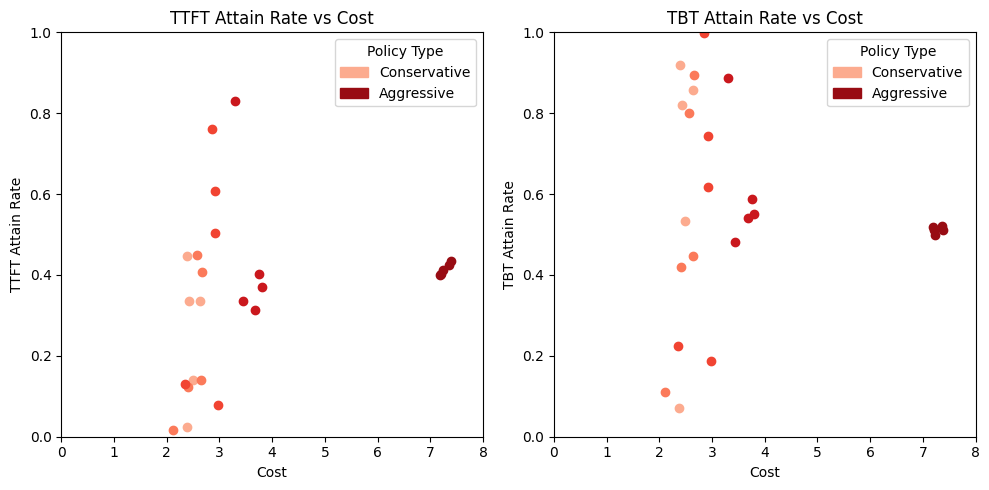

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Example lists: replace these with your actual data
# ttft_attains_list, tpot_attains_list, costs_list = [...]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Use a single colormap, e.g., Blues, with varying brightness
cmap = plt.cm.Reds
num_groups = len(ttft_attains_list)
colors = [cmap(0.3 + 0.6 * (i / (num_groups - 1))) for i in range(num_groups)]

for i, (ttft_attains, tpot_attains, costs) in enumerate(zip(ttft_attains_list, tpot_attains_list, costs_list)):
    color = colors[i]
    axes[0].scatter(costs, ttft_attains, color=color)
    axes[1].scatter(costs, tpot_attains, color=color)

axes[0].set_xlabel("Cost")
axes[0].set_ylabel("TTFT Attain Rate")
axes[0].set_title("TTFT Attain Rate vs Cost")
axes[0].set_xlim([0,8])
axes[0].set_ylim([0, 1])

axes[1].set_xlabel("Cost")
axes[1].set_ylabel("TBT Attain Rate")
axes[1].set_title("TBT Attain Rate vs Cost")
axes[1].set_xlim([0,8])
axes[1].set_ylim([0, 1])

# Add a custom legend explaining brightness
bright_patch = mpatches.Patch(color=colors[0], label="Conservative")
dark_patch = mpatches.Patch(color=colors[-1], label="Aggressive")
for ax in axes:
    ax.legend(handles=[bright_patch, dark_patch], title="Policy Type")

plt.tight_layout()
plt.show()